# Uncertainty analysis - Dentate gyrus

## Library imports

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import scanpy as sc
import scvelo as scv
import scvi
from scvelo.plotting.simulation import compute_dynamics
from velovi import preprocess_data, VELOVI
from velovi._model import _compute_directional_statistics_tensor

sys.path.append("../..")
from paths import DATA_DIR, FIG_DIR

Global seed set to 0


## General settings

In [2]:
scvi.settings.dl_pin_memory_gpu_training = False

In [3]:
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map='viridis')

In [4]:
SAVE_FIGURES = True
if SAVE_FIGURES:
    os.makedirs(FIG_DIR / 'dentategyrus', exist_ok=True)

## Function definition

In [5]:
def fit_velovi(bdata):
    VELOVI.setup_anndata(bdata, spliced_layer="Ms", unspliced_layer="Mu")

    vae = VELOVI(bdata)

    vae.train()

    df = vae.history["elbo_train"].iloc[20:].reset_index().rename(columns={'elbo_train': 'elbo'})
    df['set'] = 'train'

    _df = vae.history["elbo_validation"].iloc[20:].reset_index().rename(columns={'elbo_validation': 'elbo'})
    _df['set'] = 'validation'

    df = pd.concat([df, _df], axis=0).reset_index(drop=True)

    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 4))
        sns.lineplot(data=df, x='epoch', y='elbo', hue='set', palette=['#0173B2', '#DE8F05'], ax=ax)

    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    bdata.layers["velocities_velovi"] = velocities / scaling
    bdata.layers["latent_time_velovi"] = latent_time

    bdata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    bdata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    bdata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    bdata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    bdata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    bdata.var['fit_scaling'] = 1.0

    return vae

In [6]:
def compute_sign_variance(adata, vae):
    v_stack = vae.get_velocity(n_samples=50, velo_statistic="mean", return_mean=False)
    pos_freq = (v_stack >= 0).mean(0)
    # neg_freq = (v_stack < 0).mean(0)

    adata.layers["velocity"] = v_stack.mean(0)

    var_freq = pos_freq * (1 - pos_freq)
    adata.obs["sign_var"] = var_freq.mean(1)

    adata.layers["sign_var"] = var_freq
    adata.layers["variance"] = v_stack.var(0)

In [7]:
def compute_sign_var_score(adata, labels_key, vae):
    compute_sign_variance(adata, vae)

    sign_var_df = adata.to_df("sign_var")
    expr_df = adata.to_df("Ms")

    prod_df = sign_var_df * np.abs(expr_df)
    prod_df[labels_key] = adata.obs[labels_key]
    prod_df = prod_df.groupby(labels_key).mean()

    sign_var_df[labels_key] = adata.obs[labels_key]
    sign_var_df = sign_var_df.groupby(labels_key).mean()

    # max over clusters for a gene
    return sign_var_df.mean(0)

In [8]:
def gene_rank(adata, vkey="velocities_velovi"):
    from scipy.stats import rankdata
    scv.tl.velocity_graph(adata, vkey=vkey)
    tm = scv.utils.get_transition_matrix(
        adata, vkey=vkey, use_negative_cosines=True, self_transitions=True
    )
    tm.setdiag(0)
    adata.layers["Ms_extrap"] = tm @ adata.layers["Ms"]
    adata.layers["Ms_delta"] = adata.layers["Ms_extrap"] - adata.layers["Ms"]

    prod = adata.layers["Ms_delta"] * adata.layers[vkey]
    ranked = rankdata(prod, axis=1)
    adata.layers["product_score"] = prod
    adata.layers["ranked_score"] = ranked

In [9]:
def plot_phase_portrait(adata, gene, color, permuted=False, figsize=(6, 6)):
    fig, ax = plt.subplots(figsize=figsize)

    df = pd.DataFrame(
        {
            'unspliced': adata[:, gene].layers['Mu'].squeeze().copy(),
            'spliced': adata[:, gene].layers['Ms'].squeeze().copy(),
            'color': color
        }
    )

    with mplscience.style_context():
        sns.scatterplot(data=df, x='spliced', y='unspliced', c=color, s=25, ax=ax);

        _, unspliced, spliced = compute_dynamics(adata, basis=gene, extrapolate=True, sort=True)
        df = pd.DataFrame(
            {
                'unspliced': unspliced.squeeze(),
                'spliced': spliced.squeeze(),
            }
        )

        ax.plot(spliced, unspliced, color="purple", linewidth=2)

        spliced_steady_state = np.linspace(np.min(spliced), np.max(spliced))
        unspliced_steady_state = adata.var.loc[gene, 'fit_gamma'] / adata.var.loc[gene, 'fit_beta'] * (spliced_steady_state - np.min(spliced_steady_state)) + np.min(unspliced)
        ax.plot(spliced_steady_state, unspliced_steady_state, color='purple', linestyle="--", linewidth=2);

    ax.axis('off')
    
    if SAVE_FIGURES:
        if permuted:
            fname = f'phase_portrait_{gene}_permuted'
        else:
            fname = f'phase_portrait_{gene}'
        fig.savefig(
            FIG_DIR / 'dentategyrus' / f'{fname}.svg',
            format="svg",
            transparent=True,
            bbox_inches='tight'
        )

In [10]:
def plot_perm_scores(adata, perm_scores, gene, color_label, figsize=(6, 4)):
    df = pd.DataFrame(perm_scores.loc[gene])
    df["Cell type"] = df.index
    order = adata.obs[color_label].cat.categories.tolist()
    
    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=figsize)
        sns.barplot(
            data=df,
            y=gene,
            x="Cell type",
            palette=adata.uns[f"{color_label}_colors"],
            order=order,
            ax=ax,
        )

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / 'dentategyrus' / f'permutation_score_{gene}.svg',
            format="svg",
            transparent=True,
            bbox_inches='tight'
        )

## Data loading

In [11]:
adata = scv.datasets.dentategyrus(DATA_DIR / "dentategyrus" / "dentategyrus.h5ad")
adata

AnnData object with n_obs × n_vars = 2930 × 13913
    obs: 'clusters', 'age(days)', 'clusters_enlarged'
    uns: 'clusters_colors'
    obsm: 'X_umap'
    layers: 'ambiguous', 'spliced', 'unspliced'

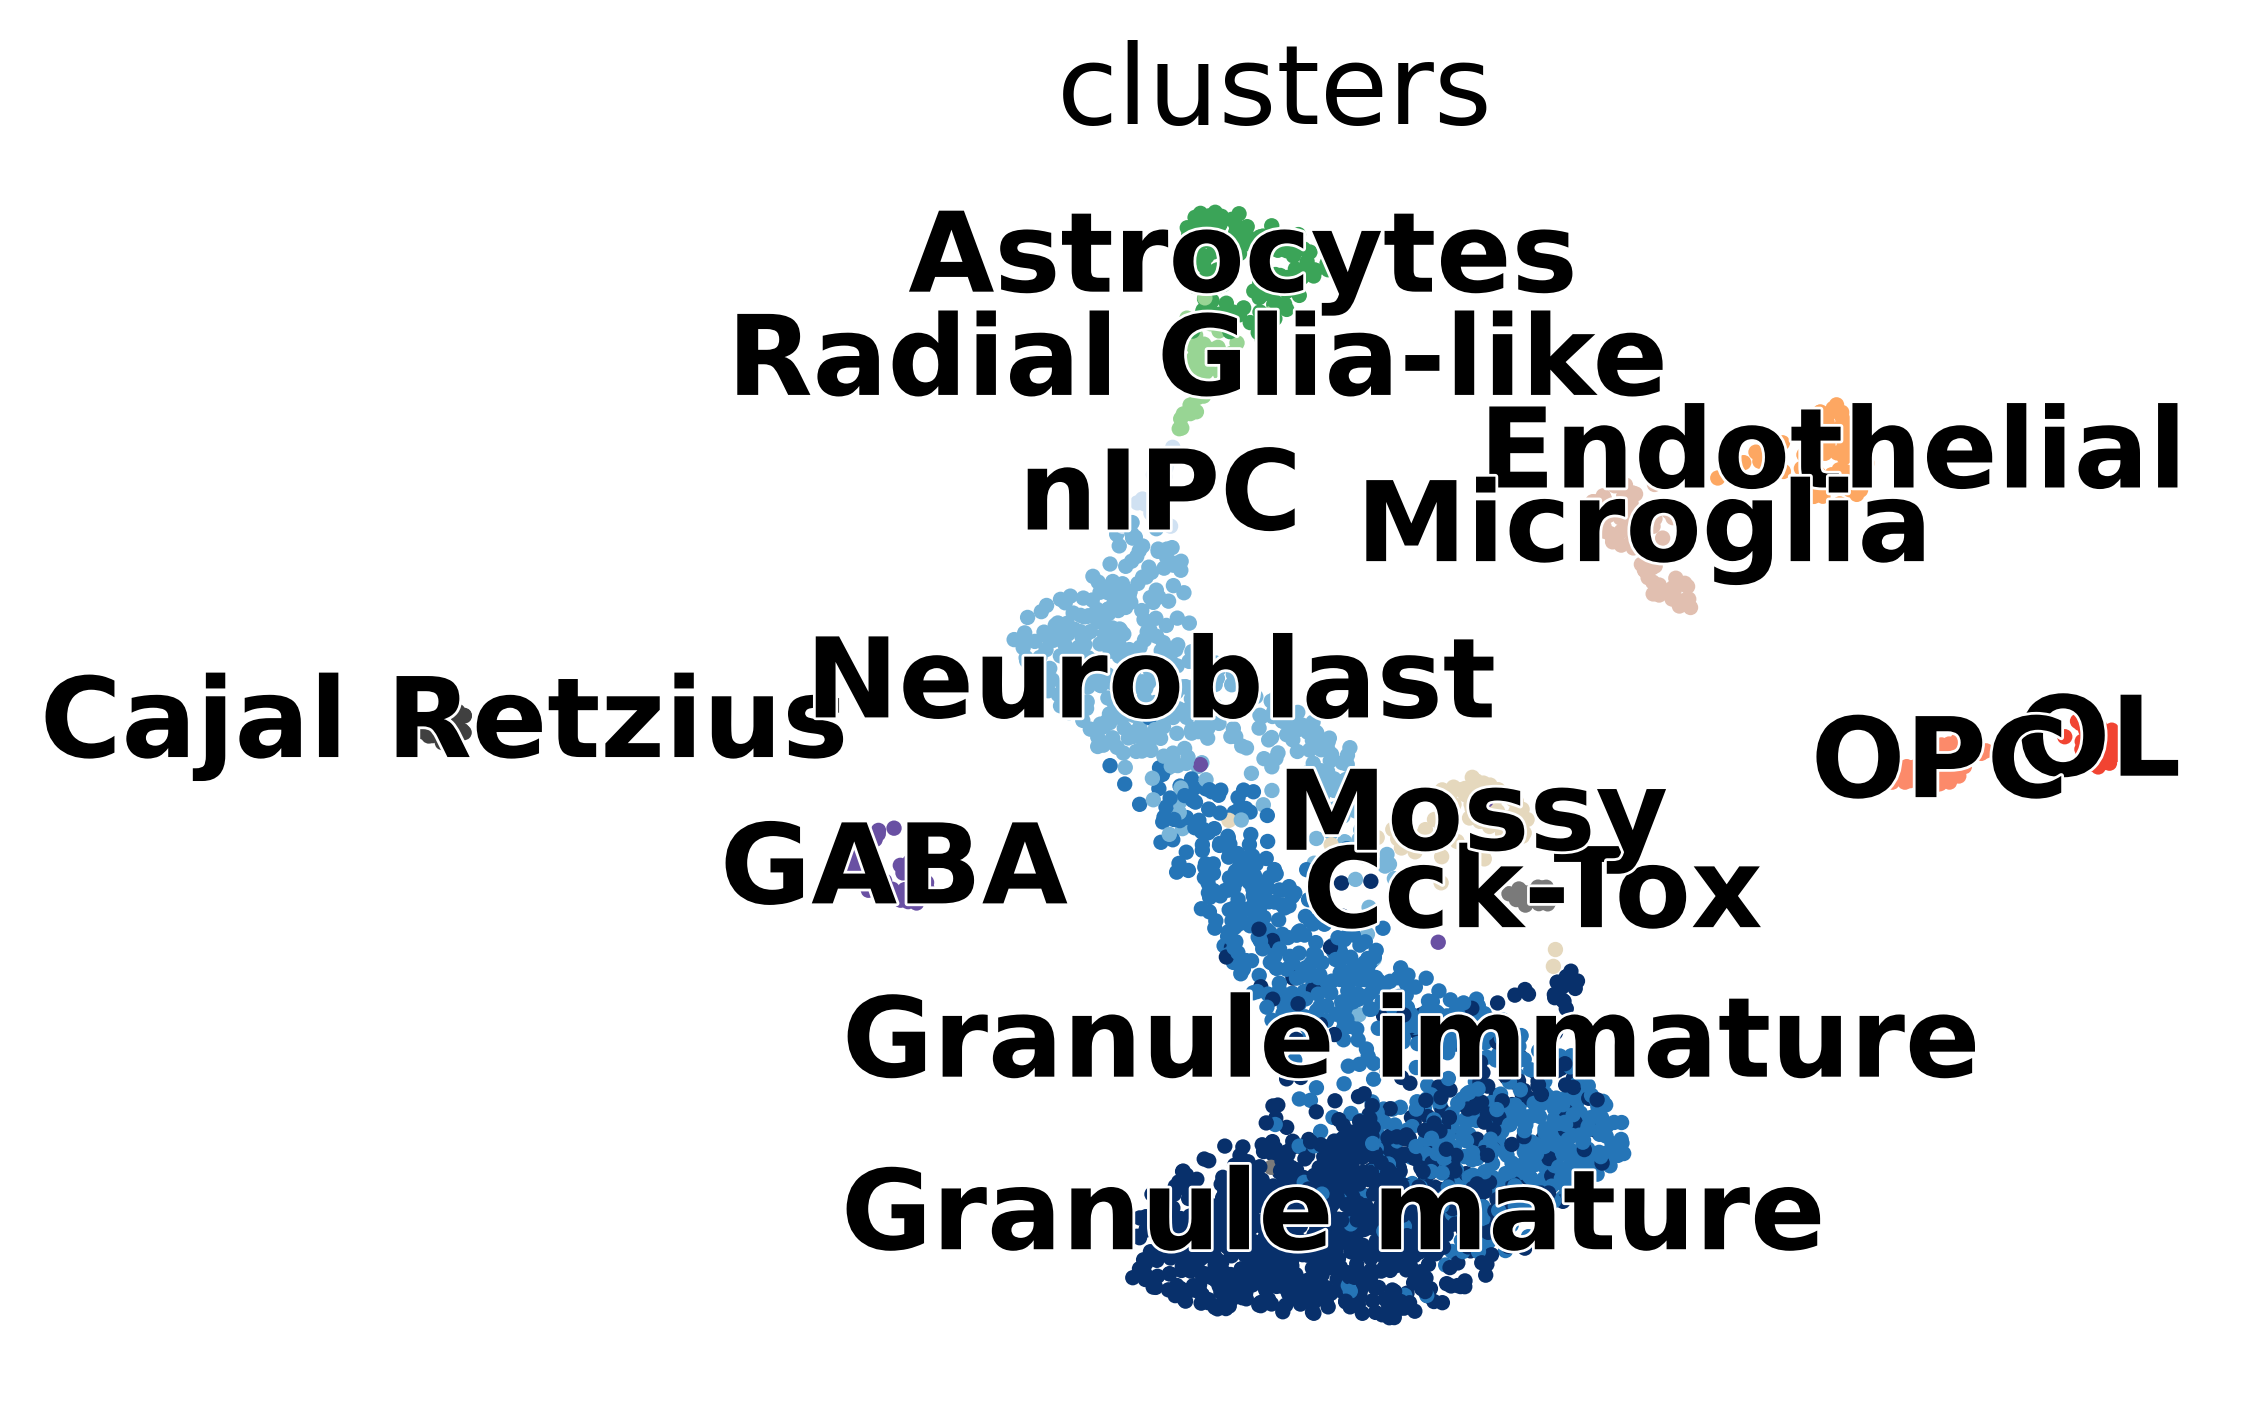

In [12]:
scv.pl.scatter(adata, basis='umap', c='clusters', dpi=200)

## Data preprocessing

In [13]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
adata = preprocess_data(adata)

Filtered out 10340 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


## Model training

/home/icb/philipp.weiler/miniconda3/envs/velovi-py39/lib/python3.9/site-packages/torch/distributed/_sharded_tensor/__init__.py:8: DeprecationWarning: torch.distributed._sharded_tensor will be deprecated, use torch.distributed._shard.sharded_tensor instead
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 359/500:  72%|███████▏  | 359/500 [01:12<00:28,  4.95it/s, loss=-1.89e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1767.121. Signaling Trainer to stop.


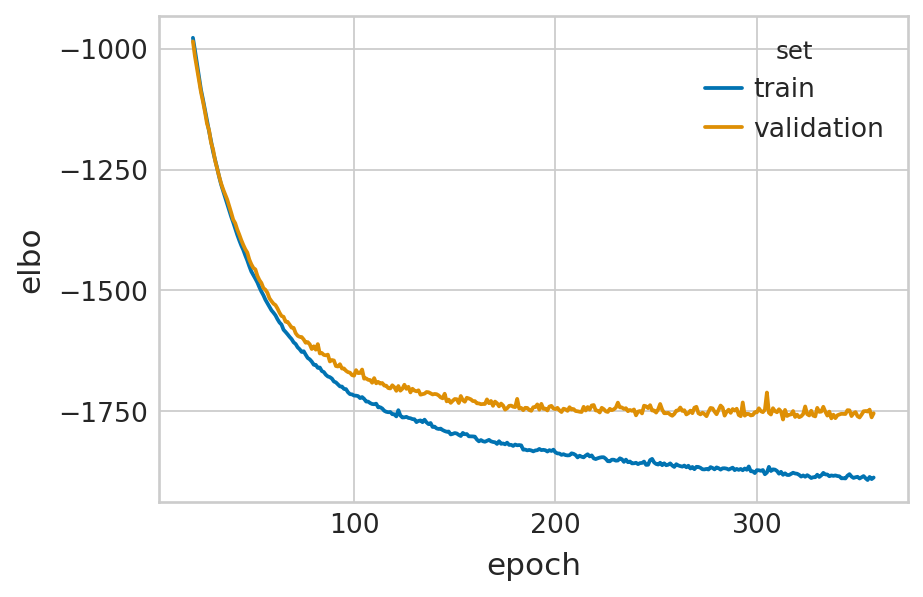

In [14]:
vae = fit_velovi(adata)

In [15]:
scv.tl.velocity_graph(adata, vkey="velocities_velovi", sqrt_transform=False)
scv.tl.velocity_embedding(
    adata, vkey="velocities_velovi", use_negative_cosines=True, self_transitions=True
)

computing velocity graph (using 1/64 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velocities_velovi_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocities_velovi_umap', embedded velocity vectors (adata.obsm)


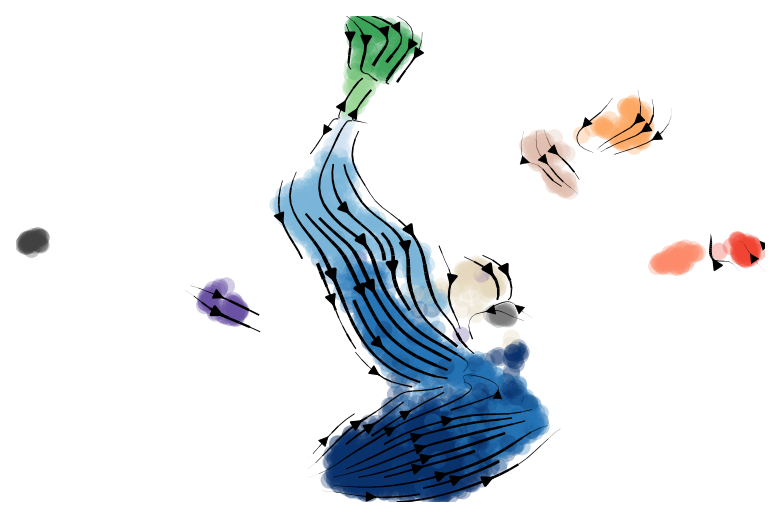

In [16]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.velocity_embedding_stream(
        adata, vkey="velocities_velovi", color=["clusters"], cmap="viridis", legend_loc=False, title='', ax=ax
    )

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'dentategyrus' / 'velocity_stream.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )

## Uncertainty

#### Intrinsic

In [17]:
udf, _ = vae.get_directional_uncertainty(n_samples=100)

INFO     velovi: Sampling from model...                                                      
INFO     velovi: Computing the uncertainties...                                              


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 2930 out of 2930 | elapsed:   16.1s finished


In [18]:
for c in udf.columns:
    adata.obs[c] = np.log10(udf[c].values)

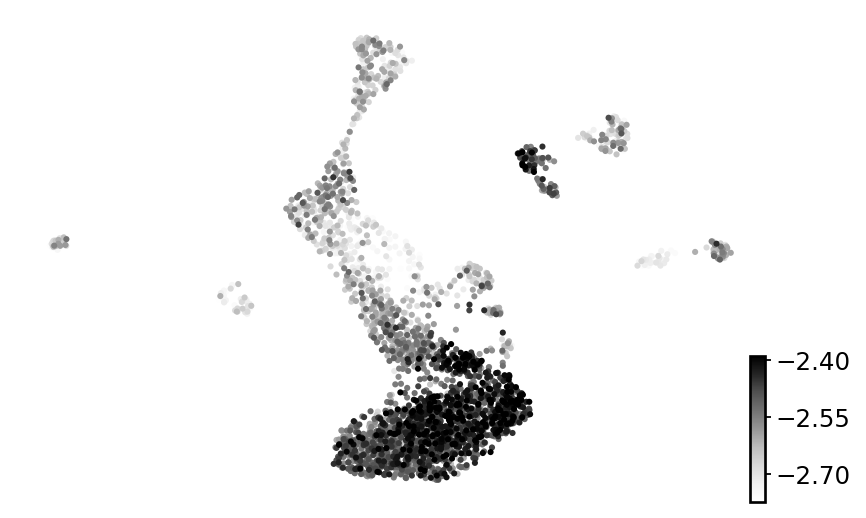

In [19]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.umap(adata, color='directional_cosine_sim_variance', perc=[5, 95], title='', cmap="Greys", ax=ax)

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'dentategyrus' / 'directional_cosine_sim_variance_initrinsic_grey.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )

#### Extrinsic

In [20]:
extrapolated_cells_list = []
for i in range(25):
    vkey = "velocities_velovi_{i}".format(i=i)
    v = vae.get_velocity(n_samples=1, velo_statistic="mean")
    adata.layers[vkey] = v
    scv.tl.velocity_graph(adata, vkey=vkey, sqrt_transform=False, approx=True)
    t_mat = scv.utils.get_transition_matrix(
        adata, vkey=vkey, self_transitions=True, use_negative_cosines=True
    )
    extrapolated_cells = np.asarray(t_mat @ adata.layers["Ms"])
    extrapolated_cells_list.append(extrapolated_cells)
extrapolated_cells = np.stack(extrapolated_cells_list)

computing velocity graph (using 1/64 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocities_velovi_0_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 1/64 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocities_velovi_1_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 1/64 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocities_velovi_2_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 1/64 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocities_velovi_3_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 1/64 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocities_velovi_4_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 1/64 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocities_velovi_5_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 1/64 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocities_velovi_6_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 1/64 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocities_velovi_7_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 1/64 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocities_velovi_8_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 1/64 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocities_velovi_9_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 1/64 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocities_velovi_10_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 1/64 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocities_velovi_11_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 1/64 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocities_velovi_12_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 1/64 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocities_velovi_13_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 1/64 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocities_velovi_14_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 1/64 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocities_velovi_15_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 1/64 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocities_velovi_16_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 1/64 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocities_velovi_17_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 1/64 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocities_velovi_18_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 1/64 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocities_velovi_19_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 1/64 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocities_velovi_20_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 1/64 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocities_velovi_21_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 1/64 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocities_velovi_22_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 1/64 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocities_velovi_23_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 1/64 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocities_velovi_24_graph', sparse matrix with cosine correlations (adata.uns)


In [21]:
df, _ = _compute_directional_statistics_tensor(extrapolated_cells, n_jobs=4, n_cells=adata.n_obs)

INFO     velovi: Computing the uncertainties...                                              


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 2868 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 2930 out of 2930 | elapsed:    2.7s finished


In [22]:
for c in df.columns:
    adata.obs[c + "_extrinsic"] = np.log10(df[c].values)

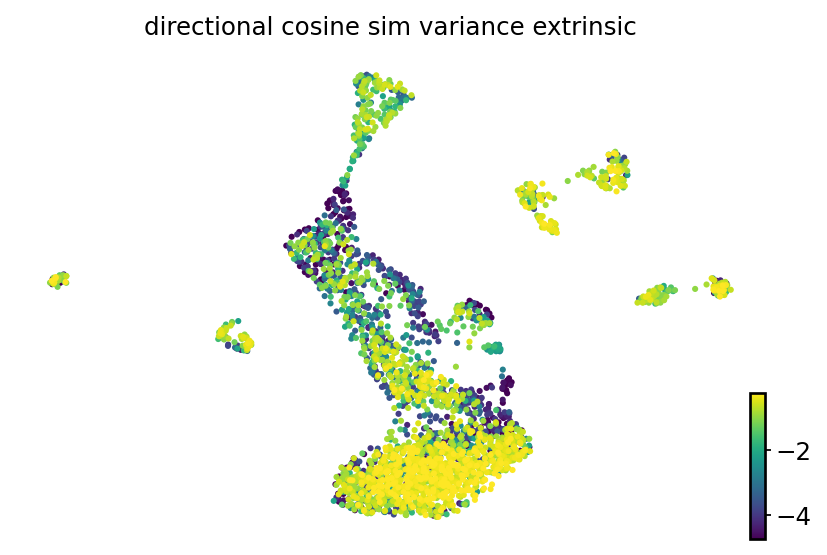

In [23]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.umap(adata, color='directional_cosine_sim_variance_extrinsic', perc=[5, 95], cmap='viridis', ax=ax)

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'dentategyrus' / 'directional_cosine_sim_variance_extrinsic.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )

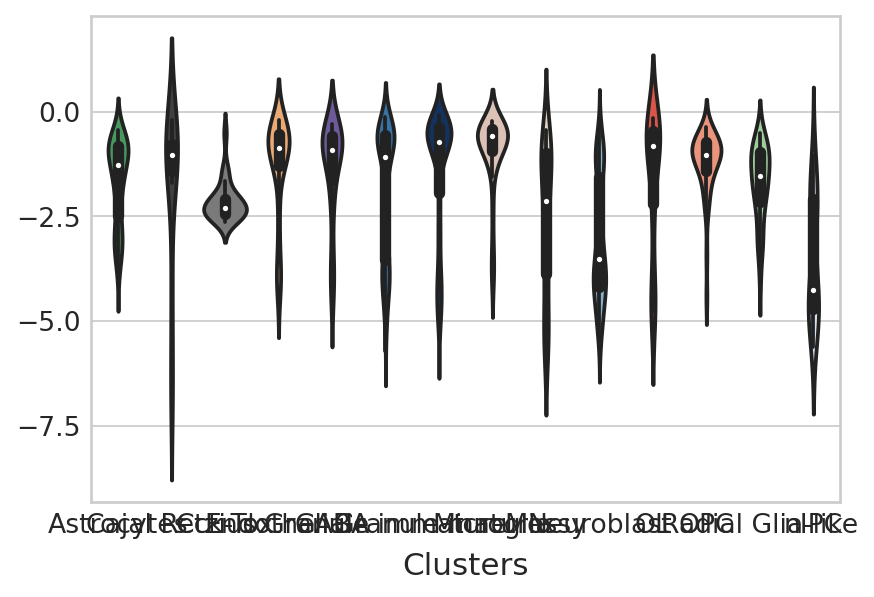

In [24]:
df = pd.DataFrame(
    {
        'Clusters': adata.obs['clusters'],
        'Extrinsic directional cosine sim. variance': adata.obs['directional_cosine_sim_variance_extrinsic']
    }
)
palette = dict(zip(adata.obs['clusters'].cat.categories, adata.uns['clusters_colors']))

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.violinplot(data=df, x="Clusters", y="Extrinsic directional cosine sim. variance", palette=palette, ax=ax);
    ax.set_ylabel('')

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'dentategyrus' / 'extrinsic_directional_cosine_sim_variance_violin.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )

## Velocity coherence

In [25]:
sign_score = compute_sign_var_score(adata, 'clusters', vae)

In [26]:
gene_rank(adata)

computing velocity graph (using 1/64 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velocities_velovi_graph', sparse matrix with cosine correlations (adata.uns)


### Granule mature cells

In [27]:
cell_subset = adata.obs.query("clusters == 'Granule mature'").index
cluster_data = adata[cell_subset]
cluster_data.obs['mean_product_score_per_cell_granule_mature'] = cluster_data.layers['product_score'].mean(axis=1)
cluster_data.var['mean_product_score_per_gene_granule_mature'] = cluster_data.layers['product_score'].mean(axis=0)

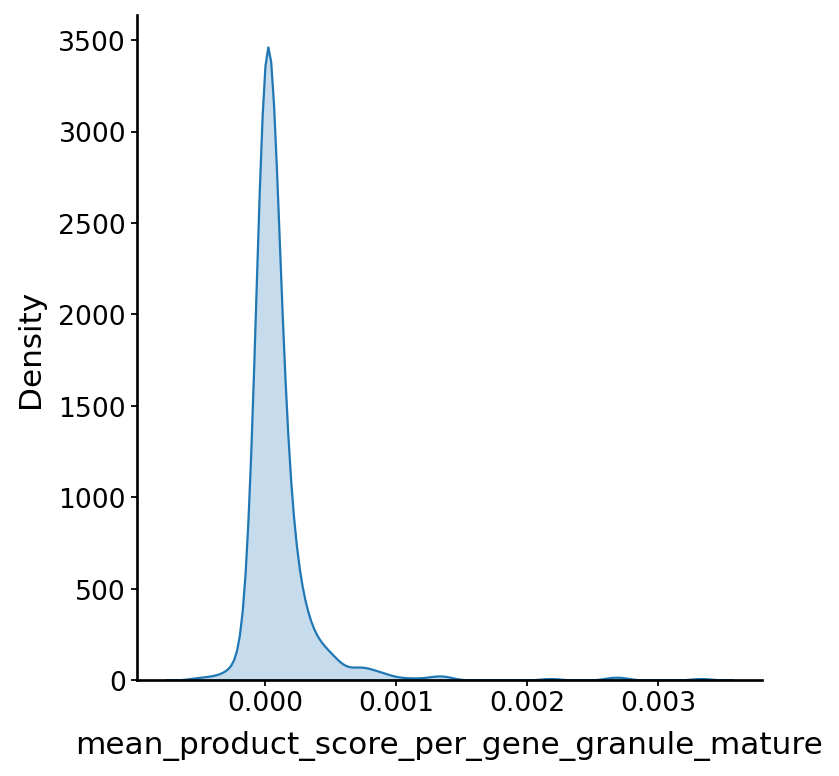

In [28]:
with mplscience.style_context():
    fig = sns.displot(
        data=cluster_data.var,
        x='mean_product_score_per_gene_granule_mature',
        kind='kde',
        fill=True
    );

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'dentategyrus' / 'mean_product_score_per_gene_granule_mature.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )

### OP cells

In [29]:
cell_subset = adata.obs.query("clusters == 'OPC'").index
cluster_data = adata[cell_subset]
cluster_data.obs['mean_product_score_per_cell_opc'] = cluster_data.layers['product_score'].mean(axis=1)
cluster_data.var['mean_product_score_per_gene_opc'] = cluster_data.layers['product_score'].mean(axis=0)

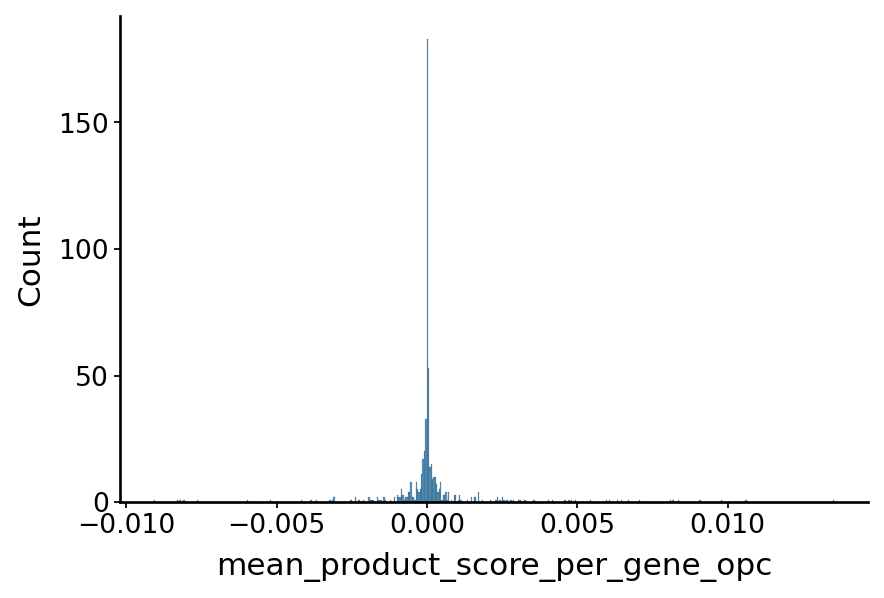

In [30]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.histplot(data=cluster_data.var, x='mean_product_score_per_gene_opc', ax=ax);

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'dentategyrus' / 'mean_product_score_per_gene_op_histogram.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )

### OL cells

In [31]:
cell_subset = adata.obs.query("clusters == 'OL'").index
cluster_data = adata[cell_subset]
cluster_data.obs['mean_product_score_per_cell_ol'] = cluster_data.layers['product_score'].mean(axis=1)
cluster_data.var['mean_product_score_per_gene_ol'] = cluster_data.layers['product_score'].mean(axis=0)

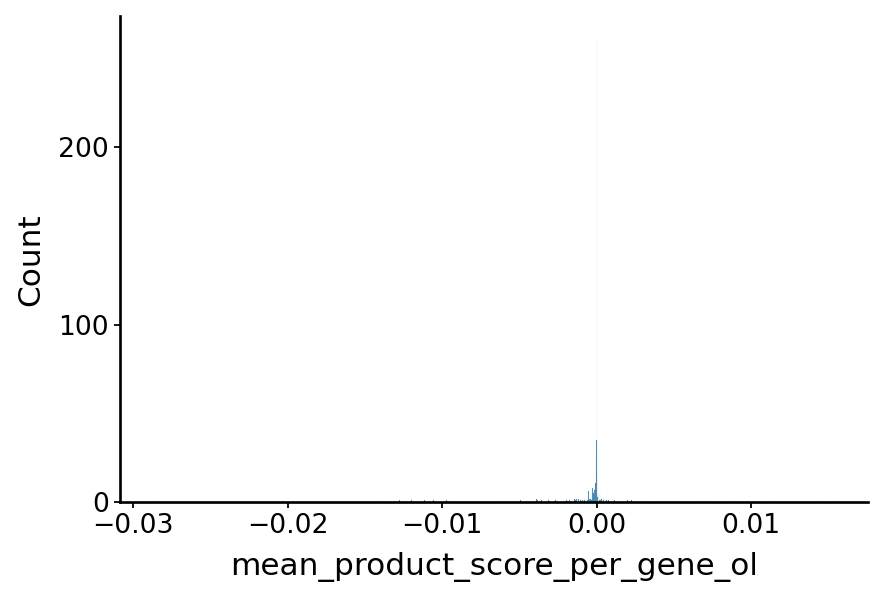

In [32]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.histplot(data=cluster_data.var, x='mean_product_score_per_gene_ol', ax=ax);

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'dentategyrus' / 'mean_product_score_per_gene_ol_histogram.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )

### Microglia

In [33]:
cell_subset = adata.obs.query("clusters == 'Microglia'").index
cluster_data = adata[cell_subset]
cluster_data.obs['mean_product_score_per_cell_microglia'] = cluster_data.layers['product_score'].mean(axis=1)
cluster_data.var['mean_product_score_per_gene_microglia'] = cluster_data.layers['product_score'].mean(axis=0)

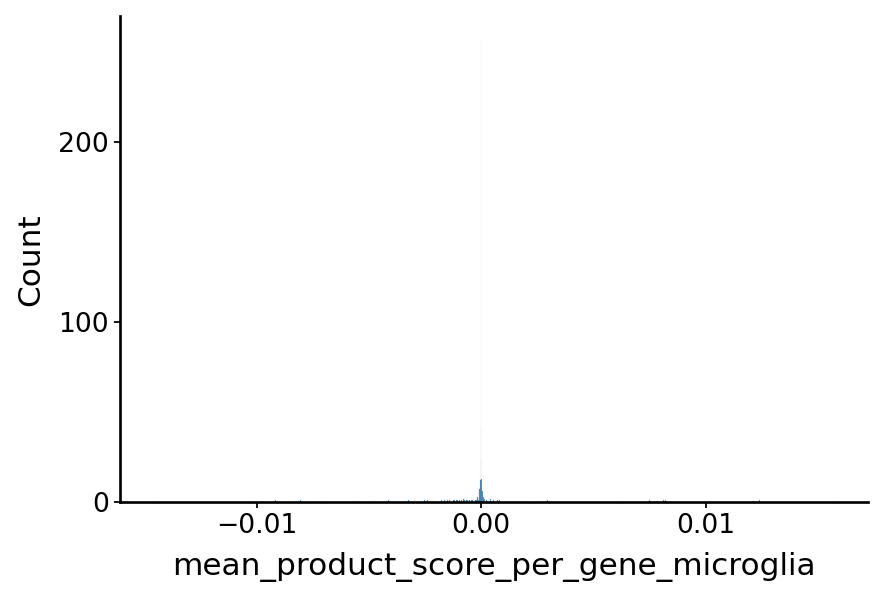

In [34]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.histplot(data=cluster_data.var, x='mean_product_score_per_gene_microglia', ax=ax);

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'dentategyrus' / 'mean_product_score_per_gene_microglia_histogram.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )

### Endothelial cells

In [35]:
cell_subset = adata.obs.query("clusters == 'Endothelial'").index
cluster_data = adata[cell_subset]
cluster_data.obs['mean_product_score_per_cell_endothelial'] = cluster_data.layers['product_score'].mean(axis=1)
cluster_data.var['mean_product_score_per_gene_endothelial'] = cluster_data.layers['product_score'].mean(axis=0)

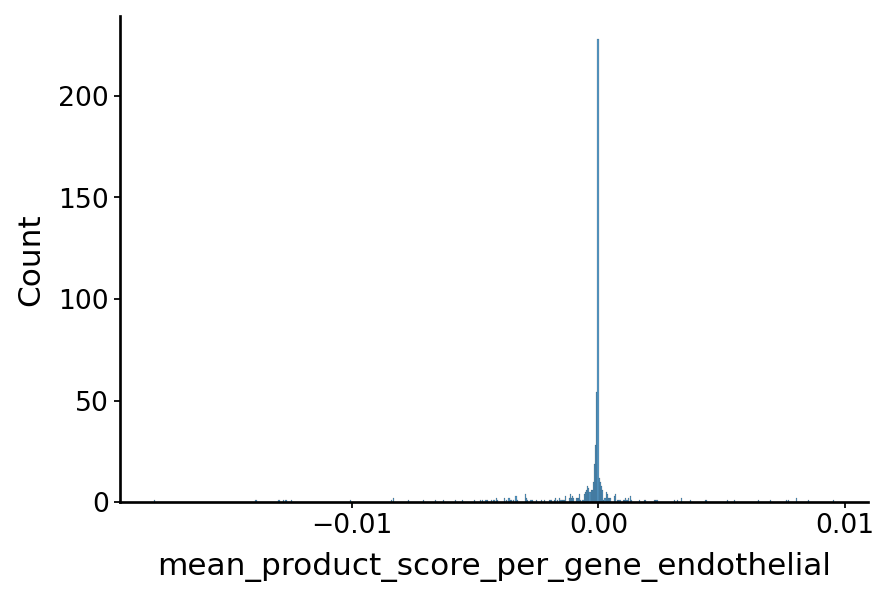

In [36]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.histplot(data=cluster_data.var, x='mean_product_score_per_gene_endothelial', ax=ax);

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'dentategyrus' / 'mean_product_score_per_gene_endothelial_histogram.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )

## Permutation score evaluation

In [37]:
perm_scores, permuted_adata = vae.get_permutation_scores(labels_key='clusters')

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       


In [38]:
full_perm_df = pd.DataFrame(columns=["Score", "Dataset"])

max_ratio = np.nanmax(perm_scores.values, axis=1)
scores = max_ratio.tolist()
dataset = ['Dentategyrus'] * len(max_ratio)

full_perm_df["Score"] = scores
full_perm_df["Dataset"] = dataset

In [39]:
color = adata.obs['clusters'].astype(str).replace(
    dict(zip(adata.obs['clusters'].cat.categories, adata.uns['clusters_colors']))
).tolist()

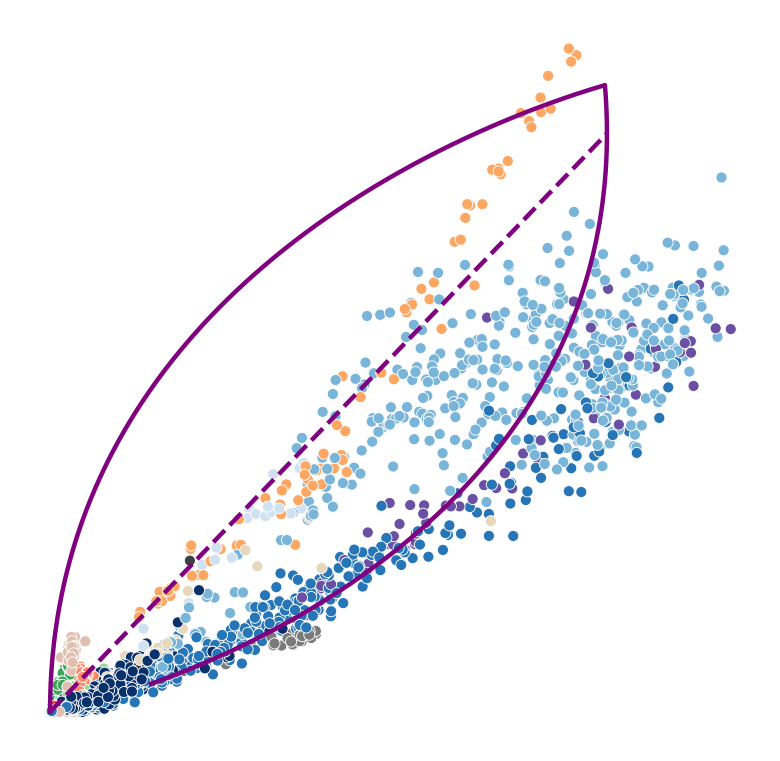

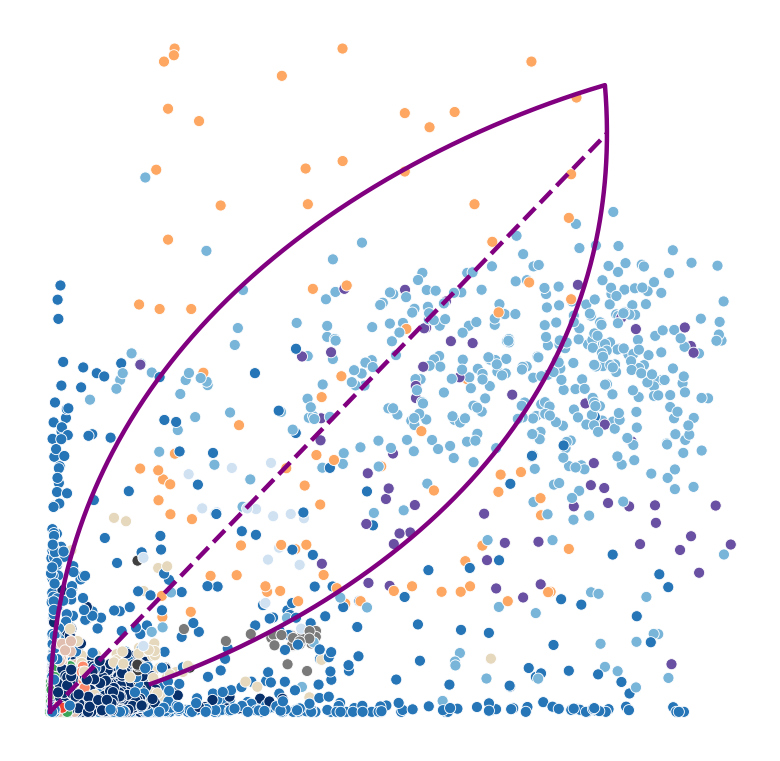

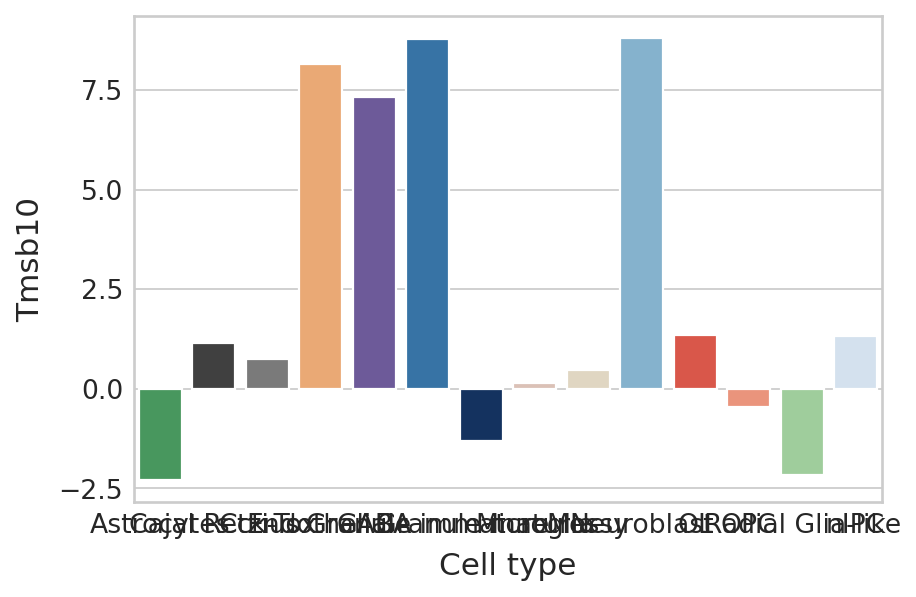

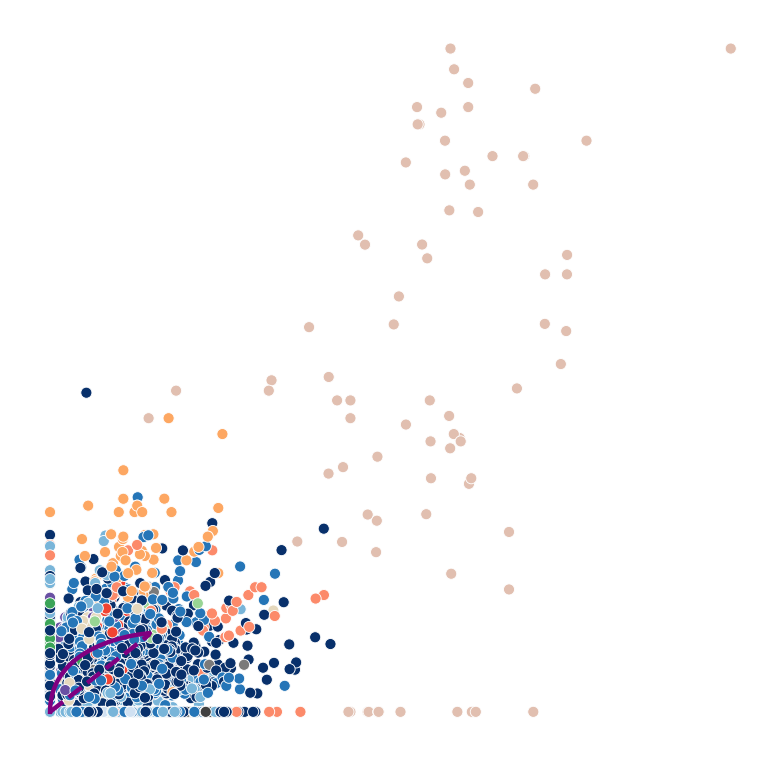

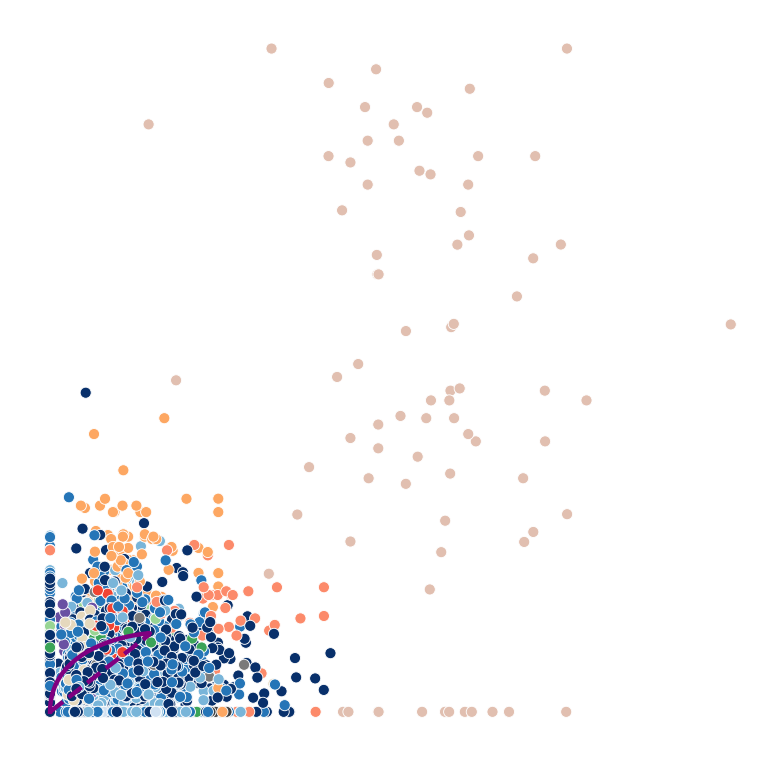

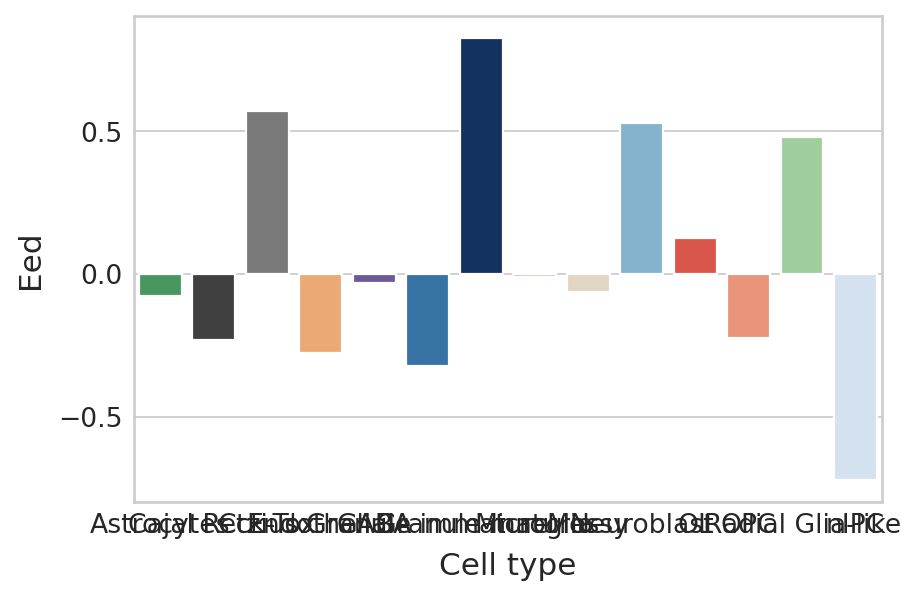

In [40]:
for gene in ['Tmsb10', 'Eed']:
    plot_phase_portrait(adata, gene, color)
    plot_phase_portrait(permuted_adata, gene, color, permuted=True)
    plot_perm_scores(adata, perm_scores, gene, 'clusters')